<a href="https://colab.research.google.com/github/yeshengw/robust-risk-aware-rl/blob/uploads/Example_3_Robust_Dynamic_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import sys

drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/Colab/RRA_RL/ex5(bear)/"
save_dir = "/content/gdrive/My Drive/Colab/RRA_RL/ex5(bear)/save"
sys.path.append("/content/gdrive/My Drive/Colab/RRA_RL/")

Mounted at /content/gdrive


In [ ]:
from parameters import *
from market_models import *
from solution import *
from metrics import *
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import yfinance as yf

In [ ]:
# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


# Networks

In [ ]:
class InnerNet(nn.Module):

    def __init__(self, n_hidden):
        super(InnerNet, self).__init__()

        self.fc_inp_h1 = nn.Linear(1, n_hidden)
        self.fc_h1_h2 = nn.Linear(n_hidden, n_hidden)
        self.fc_h2_out = nn.Linear(n_hidden, 1)
        self.myReLU = nn.ReLU()

    def forward(self, x):
        x = self.myReLU(self.fc_inp_h1(x))
        x = self.myReLU(self.fc_h1_h2(x))
        y = self.fc_h2_out(x)

        return y

class OuterNet(nn.Module):

    def __init__(self, n_feats, n_hidden, n_assets, invent_limit = 5):
        super(OuterNet, self).__init__()
        self.fc_inp_to_h1 = nn.Linear(n_feats, n_hidden)
        self.fc_h1_h2 = nn.Linear(n_hidden, n_hidden)
        self.fc_h2_out = nn.Linear(n_hidden, n_assets)
        self.invent_limit = invent_limit
        self.myReLU = nn.ReLU()

        self.mySoftmax = nn.Softmax(dim=2)
        # apply the softmax function along dim=2 (dimension of assets) (recall dim of state: (Ndt+1, Nsim, Nassets)
        # s.t. the weights of the assets sum to 1

    def forward(self, x):
        x = self.myReLU(self.fc_inp_to_h1(x))
        x = self.myReLU(self.fc_h1_h2(x))
        y = self.mySoftmax(self.fc_h2_out(x))

        return y

# Agents
#### Formula 2.3:    
$X^\phi=-\sum^{T-1}_{i=0}\phi_i X_i+q_T^\phi X_T=\sum^T_{i=1}q_i^\phi (X_i-X_{i-1})$

In [ ]:
class EOU_Agent(Agent):
  def __init__(self, market_model, sim_params, train_params, device, outer_net, net_name, requires_update = True):
    Agent.__init__(self, market_model, sim_params, train_params, device, outer_net, net_name, requires_update)
    Ndt, _, Nsims, Nassets, _, _, _ = self.sim_params.GetParams()

    self.X_phi_history = np.empty((Nsims, 0))

    self.wt_history = []
    self.daily_asset_value_history = []
    self.daily_phi_history = []

  def sim_phi(self):
    t, S = self.market_model.t, self.market_model.S
    Ndt, T, Nsims, Nassets, S0, _, _ = self.sim_params.GetParams()
            # Ndt=252, T=1, Nsim=6k, Nassets, S0=array([1])
    initial_capital = 10  # initial portfolio capital
    daily_phi_limit = torch.tensor(10).to(device)  # the agent can buy/sell at most 10 shares of an asset in a single trade day

    # S_t has dimensions time, number of simulations, number of assets
    S_t = torch.FloatTensor(S).to(device)
    # asset price change every dt
    # dimension: Ndt, Nsims, Nassets
    S_dt = S_t[1:, :, :] - S_t[:-1, :, :]

    # construct state tensor consisting of time and scaled asset price
    state = torch.zeros((Ndt + 1, Nsims, Nassets + 1)).to(device)
            # three dimensions: time, simulation runs, and 2 features
            # time feature, price feature

    state[:, :, 0] = torch.FloatTensor(t.reshape(-1,1) / t[-1]).to(device) # feature 1 normalized time between 0 and 1
    S0 = torch.FloatTensor(S0).to(device)
    # asset price scaled in terms of % difference from starting price multiplied by constant of 4 to ensure magnitude is not too small
    for i in range(Nassets):
        state[:, :, i+1] = (S_t[:,:,i] - S0) / S0 * 4 # feature 2 scaled price
    """
    S_t[trading day index, iteration index, asset index]
    original: state[:, :, 1] = (S_t[:, :, 0] - S0[0]) / S0[0] * 4
    S_t[:, :, :]: price of all assets
    S0: 1-vector
    """

    # inventory// in example 4: allocation
    w_t = self.outer_net(state)  # w_t=[trade date, iteration index, asset index]

    # step 1
    daily_phi = torch.zeros((Ndt + 1, Nsims, Nassets)).to(device)
    daily_inventory = torch.zeros((Ndt + 1, Nsims, Nassets)).to(device)  # at day 0, all 0
    daily_asset_value = torch.zeros((Ndt + 1, Nsims, Nassets)).to(device)

    daily_phi_temp = initial_capital * w_t[0, :, :] / S_t[0, :, :]  # shares bought/buy (daily transactions)
    daily_phi[0, :, :] = torch.clip(daily_phi_temp, -daily_phi_limit, daily_phi_limit)  # cap daily transaction within +/- limit
    daily_inventory[0, :, :] = daily_phi[0, :, :]  # total number of shares held, after daily tractions
    daily_asset_value[0, :, :] = daily_inventory[0, :, :] * S_t[0, :, :]  # asset value after daily transactions

    for i in range(1, Ndt+1):
      temp_portfolio_value = torch.sum(S_t[i, :, :] * daily_inventory[i-1, :, :], axis=1)
      target_inventory = (w_t[i, :, :] * temp_portfolio_value[:, None]) / S_t[i, :, :]
      daily_phi_temp = target_inventory - daily_inventory[i-1, :, :]
      daily_phi[i, :, :] = torch.clip(daily_phi_temp, -daily_phi_limit, daily_phi_limit) # cap daily transaction within +/- limit
      daily_inventory[i, :, :] = daily_phi[i, :, :] + daily_inventory[i-1, :, :]
      daily_asset_value[i, :, :] = daily_inventory[i, :, :] * S_t[i, :, :]

    # other loss = transaction cost
    transaction_cost = 0.001
    self.other_loss = torch.mean(torch.sum(torch.abs(daily_phi) * S_t, axis=(0, 2))) * transaction_cost

    X_phi_T = torch.sum(daily_asset_value[-1, :, :], axis=1)

    X_phi_T_np = X_phi_T.cpu().detach().numpy().reshape(-1,1)
    """
    reshape() X_phi_T_np such that it becomes a (Nsim, 1) "matrix", and can concatenate with X_phi_history down the line.
    X_phi_history is of dim (Nsim, 0), we concatenate along axis = 1. X_phi_T_np and X_phi_history must of the same shape except in axis=1.
    """

    # initialize array of shares bought/sold at trading times
    phi_t_np = np.zeros((Ndt + 1, Nsims, Nassets))
    # trade size is difference in inventory (initial inventory of 0)

    self.X_phi_history = np.concatenate((self.X_phi_history, X_phi_T_np), axis = 1)


    wt_np = w_t.cpu().detach().numpy()
    self.wt_history.append(wt_np)
    if len(self.wt_history) > 5:
      self.wt_history.pop(0)

    dav_np = daily_asset_value.cpu().detach().numpy()
    self.daily_asset_value_history.append(dav_np)
    if len(self.daily_asset_value_history) > 5:
      self.daily_asset_value_history.pop(0)

    dp_np = daily_phi.cpu().detach().numpy()
    self.daily_phi_history.append(dp_np)
    if len(self.daily_phi_history) > 5:
      self.daily_phi_history.pop(0)

    return X_phi_T

  def PlotCustom(self, X, Y, adversary):
    print("Outer Problem Metrics")
    self.PlotStrategy()
    print("Inner Problem Metrics")
    adversary.PrintMetrics()
    adversary.PlotHistory()
    adversary.PlotDistortion(X, Y)


  def PlotStrategy(self):
    # plot heatmaps at four quartiles
    pass

"""
Plot
ToDO: plot_1: fix alpha, beta, adjust p
ToDO: plot_2: example 1 figure 2: asset allocation with difference p value (on x axis), portfolio weights (y axis)
"""

'\nPlot\nToDO: plot_1: fix alpha, beta, adjust p\nToDO: plot_2: example 1 figure 2: asset allocation with difference p value (on x axis), portfolio weights (y axis)\n'

In [ ]:
class OU_Adversary(Adversary):
  def __init__(self, rm_params, lm_params, wass_params, train_params, device, inner_net, net_name, objective = "maximize", reset_lm = True, reset_net = False):
    Adversary.__init__(self, rm_params, lm_params, wass_params, train_params, device, inner_net, net_name, objective, reset_lm, reset_net)

  def sim_theta(self, X_phi_T, market_model):
    X_theta_T = self.inner_net(X_phi_T)
    return X_theta_T



# Parameters

In [ ]:
sim_param_dict = {
               "Nassets" : 8,
               "Nsims" : 2000,
               "S0" : np.array([1]),
               "T" : 1,
               "Ndt" : 252
                }
# for higher Nsims, the density distribution between X_phi and X_theta would overlap more

EOU_param_dict = {
              "kappa" : np.array([5]),
               "sigma" : np.array([0.8]),
                 }

LM_param_dict = { "lam": 1,
                  "mu": 80,
                  "mu_update": 1.2,
                  "update_freq": 1000
                  }


wass_param_dict = {"wass_order" : 2,
                   "wass_limit" : 0.15
                  }

train_param_dict = {"inner_epochs" : 3000,
                    "outer_epochs" : 100,
                    "plot_freq_outer" : 50,
                    "plot_freq_inner" : np.inf,
                    "inner_lr": 1e-3,
                    "outer_lr": 2e-2,
                    "freeze_market_iter": 1,
                    "freeze_inner_iter" : 1
                   }

sim_params = Sim_Params(sim_param_dict)
market_params = MarketModel_Params(EOU_param_dict, Type = "EOU")
lm_params = LM_Params(LM_param_dict)
wass_params = Wass_Params(wass_param_dict)
train_params = Train_Params(train_param_dict)

In [ ]:
tickers =  ["AAPL", "GE", "JPM", "MSFT", "VOD", "NKE", "NVDA", "MMM"]
start_date = "2004-01-01"
end_date = "2008-01-03"
data = yf.download(tickers, start=start_date, end=end_date, interval='1d')['Adj Close']

OU_model = RealData(data)
OU_model.Sim(sim_params)
OU_model.PlotSim()

Output hidden; open in https://colab.research.google.com to view.

# Results

## $\alpha = 0.1, \beta = 0.9, p = 0.75$

In [ ]:
RM_param_dict = { "alpha" : 0.1,
                  "beta" : 0.9,
                   "p" : 0.75,
                  "rm_type" : 'alpha-beta'
                  }

rm_params = RM_Params(RM_param_dict)

In [ ]:
inner_net = InnerNet(10).to(device)
outer_net = OuterNet(9, 10, 8).to(device) # change OuterNet(2, 10, 1) to OuterNet(9, 10, 8) stands for 8 assets as output
inner_name = root_dir + "inner_p_0.75"
outer_name = root_dir + "outer_p_0.75"

Outer Epoch: 0 Outer Iter: 0
Outer Problem Metrics
Inner Problem Metrics
Wass Dist History:  [0.14991632103919983, 0.14992238581180573, 0.1499304473400116, 0.1499413698911667, 0.1499541997909546]
Risk Measure X_theta History:  [-11.241360664367676, -11.241354942321777, -11.241348266601562, -11.241336822509766, -11.241323471069336]
Loss History:  [11.254170417785645, 11.254164695739746, 11.254157066345215, 11.254146575927734, 11.254133224487305]
Augmented Lagrangian lambda: 49.76794357299805 mu: 138.23999999999998


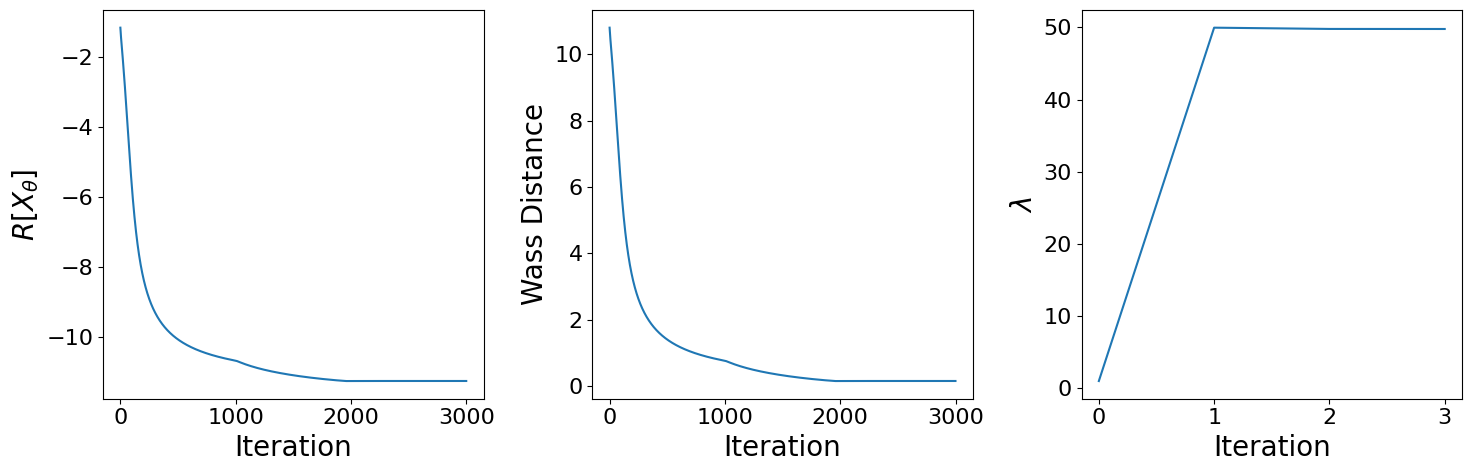

/content/gdrive/My Drive/Colab/RRA_RL/solution.py:156: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X, hist=True, kde= True, label= r'$X^{\phi}$')
/content/gdrive/My Drive/Colab/RRA_RL/solution.py:157: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Y, hist=True, kde= True, label= r'$X^{\theta}$'

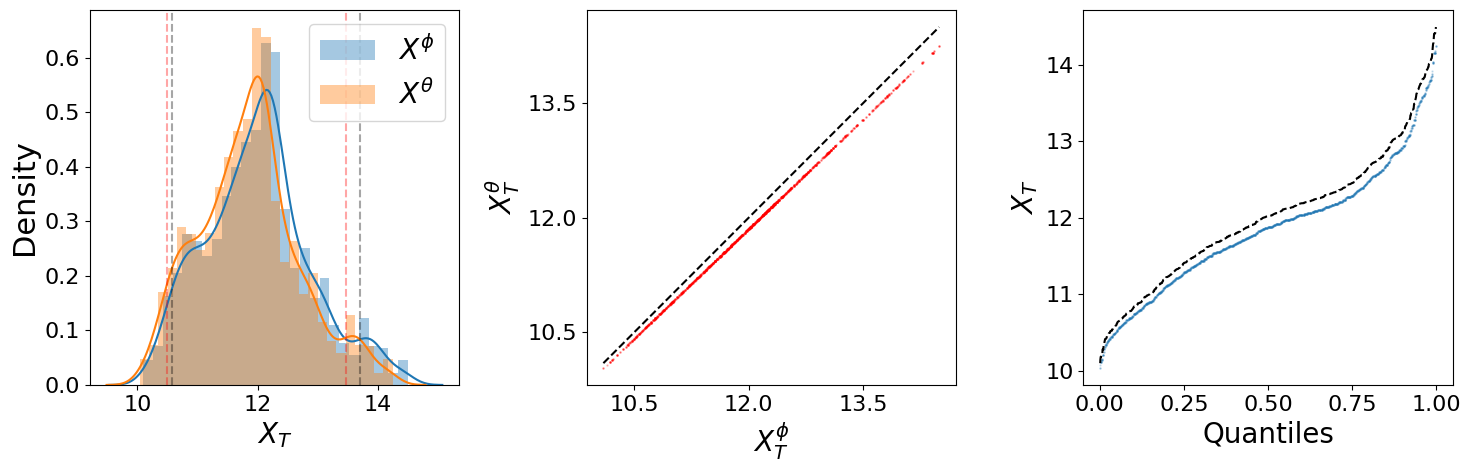

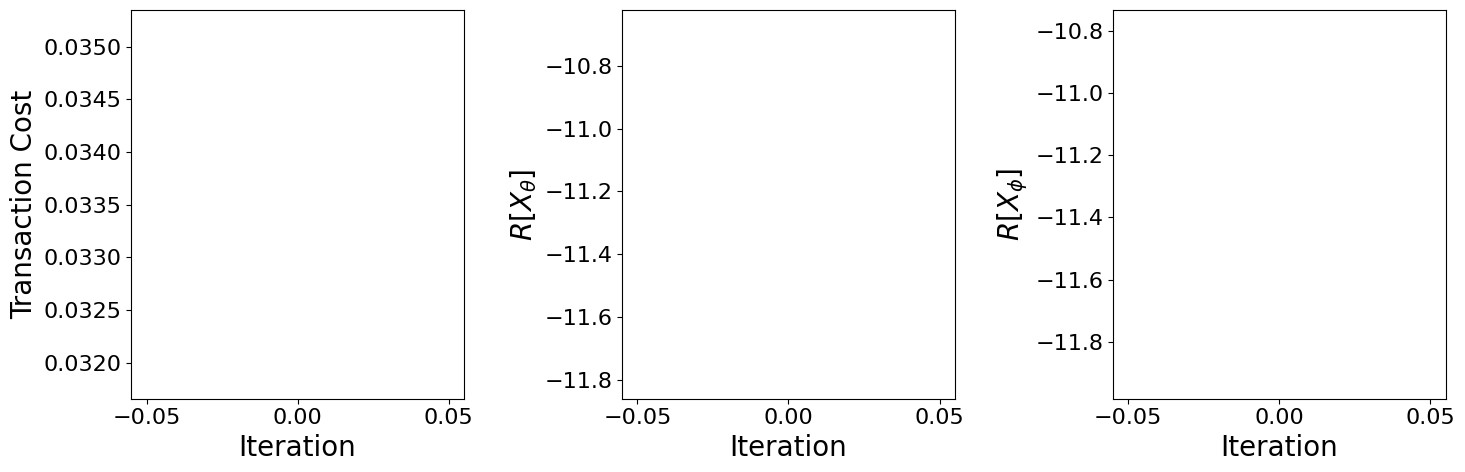

Outer Epoch: 50 Outer Iter: 0
Outer Problem Metrics
Inner Problem Metrics
Wass Dist History:  [0.14836789667606354, 0.15409556031227112, 0.16005879640579224, 0.15870285034179688, 0.15263353288173676]
Risk Measure X_theta History:  [-16.489736557006836, -16.471702575683594, -16.4575138092041, -16.460447311401367, -16.4758358001709]
Loss History:  [16.757505416870117, -1.1052024364471436, -6.819890022277832, -5.5803375244140625, 0.4461408853530884]
Augmented Lagrangian lambda: 9.470329484939578 mu: 138.23999999999998


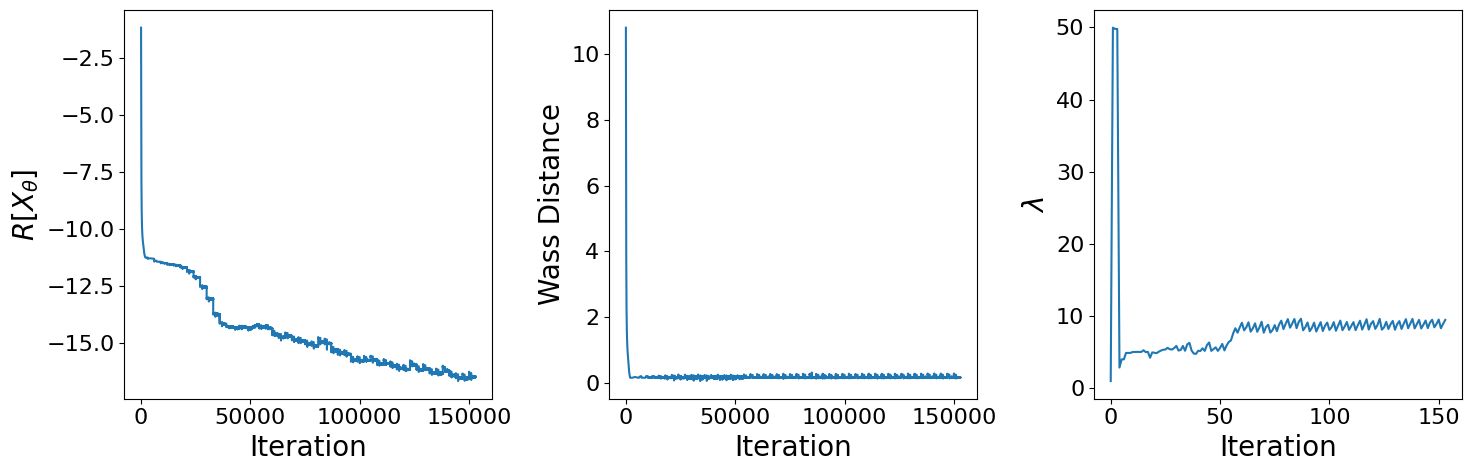

/content/gdrive/My Drive/Colab/RRA_RL/solution.py:156: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X, hist=True, kde= True, label= r'$X^{\phi}$')
/content/gdrive/My Drive/Colab/RRA_RL/solution.py:157: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Y, hist=True, kde= True, label= r'$X^{\theta}$'

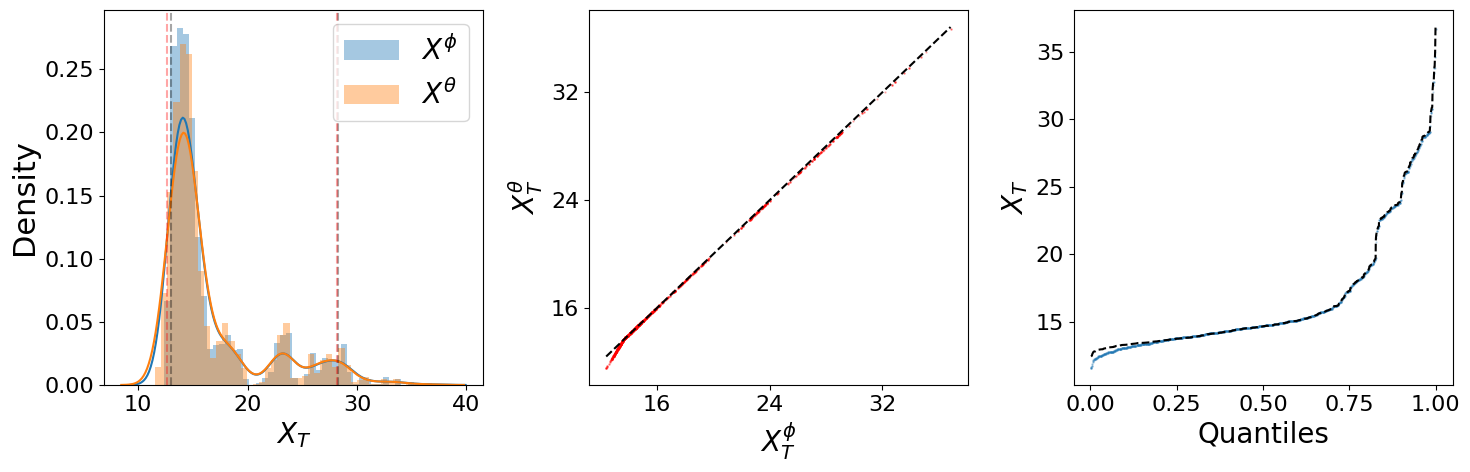

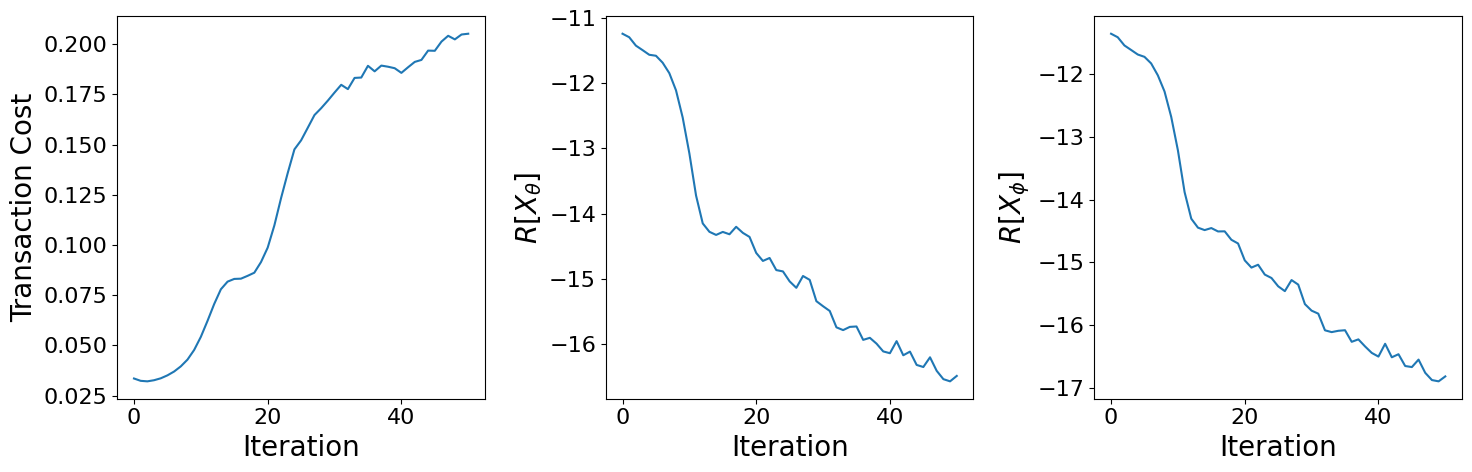

OuterNet(
  (fc_inp_to_h1): Linear(in_features=9, out_features=10, bias=True)
  (fc_h1_h2): Linear(in_features=10, out_features=10, bias=True)
  (fc_h2_out): Linear(in_features=10, out_features=8, bias=True)
  (myReLU): ReLU()
  (mySoftmax): Softmax(dim=2)
)

In [ ]:
agent = EOU_Agent(OU_model, sim_params, train_params, device, outer_net, outer_name)
adversary = OU_Adversary(rm_params, lm_params, wass_params, train_params, device, inner_net, inner_name)
agent.train(adversary)

In [ ]:
np.save(save_dir + "075/" + "wt_history.npy", agent.wt_history)
np.save(save_dir + "075/" + "daily_phi_history.npy", agent.daily_phi_history)
np.save(save_dir + "075/" + "daily_asset_value_history.npy", agent.daily_asset_value_history)
np.save(save_dir + "075/" + "x_phi.npy", agent.X_phi_history)

wt_history:
  - a list of w_t elements
  - length of the list: # outer epochs
  - each w_t element has a dimension of (Ndt+1, Nsims, Nassets)

daily_phi_history:
  - length: # outer epochs
  - daily_phi dimension: (Ndt+1, Nsims, Nassets)

daily_asset_value_history:
  - length: # outer epochs
  - daily_asset_value dimension: (Ndt+1, Nsims, Nassets)

X_phi_history
  - X_phi dimension: (Nsims, NouterEpochs)

[2.7327214e-15 8.0389957e-15 1.1738745e-12 2.1546172e-09 8.6857638e-15
 5.0125269e-05 9.9994981e-01 4.5555589e-17]


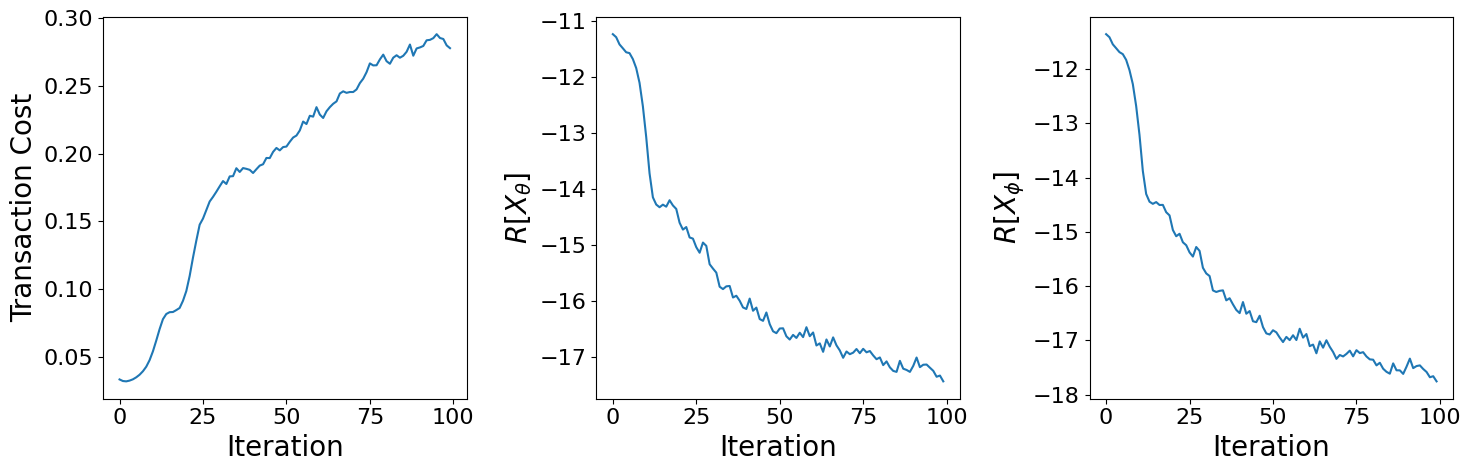

In [ ]:
wt = agent.wt_history[-1]
print(wt[-1, -1])
agent.PlotHistory()

## $\alpha = 0.1, \beta = 0.9, p = 0.9$

In [ ]:
RM_param_dict = { "alpha" : 0.1,
                  "beta" : 0.9,
                   "p" : 0.9,
                  "rm_type" : 'alpha-beta'
                  }

rm_params = RM_Params(RM_param_dict)

In [ ]:
inner_net = InnerNet(10).to(device)
outer_net = OuterNet(9, 10, 8).to(device)
inner_name = root_dir + "inner_p_0.9"
outer_name = root_dir + "outer_p_0.9"

Outer Epoch: 0 Outer Iter: 0
Outer Problem Metrics
Inner Problem Metrics
Wass Dist History:  [0.14990082383155823, 0.14988991618156433, 0.14988189935684204, 0.1498764306306839, 0.14987371861934662]
Risk Measure X_theta History:  [-10.737241744995117, -10.737251281738281, -10.737258911132812, -10.737264633178711, -10.737266540527344]
Loss History:  [10.750504493713379, 10.750514030456543, 10.750520706176758, 10.75052547454834, 10.750529289245605]
Augmented Lagrangian lambda: 74.6768941307068 mu: 138.23999999999998


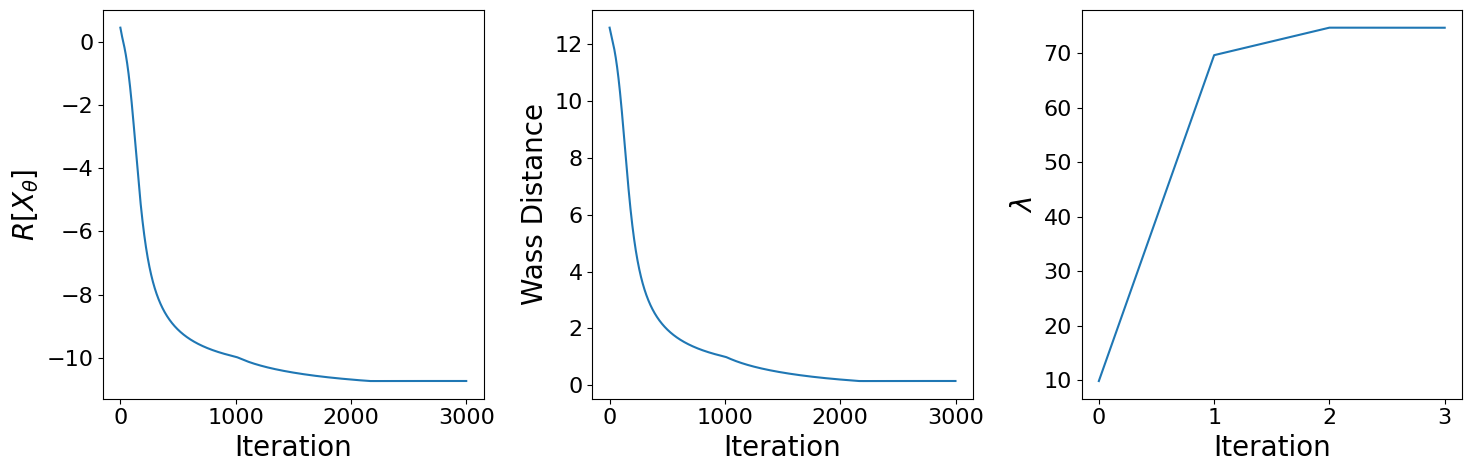

/content/gdrive/My Drive/Colab/RRA_RL/solution.py:156: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X, hist=True, kde= True, label= r'$X^{\phi}$')
/content/gdrive/My Drive/Colab/RRA_RL/solution.py:157: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Y, hist=True, kde= True, label= r'$X^{\theta}$'

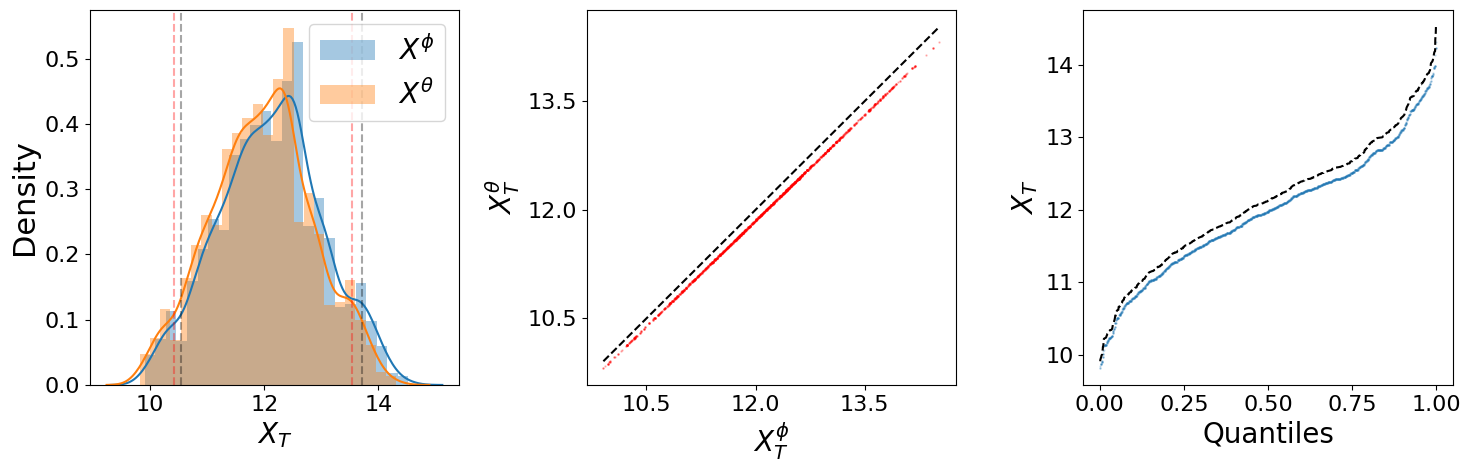

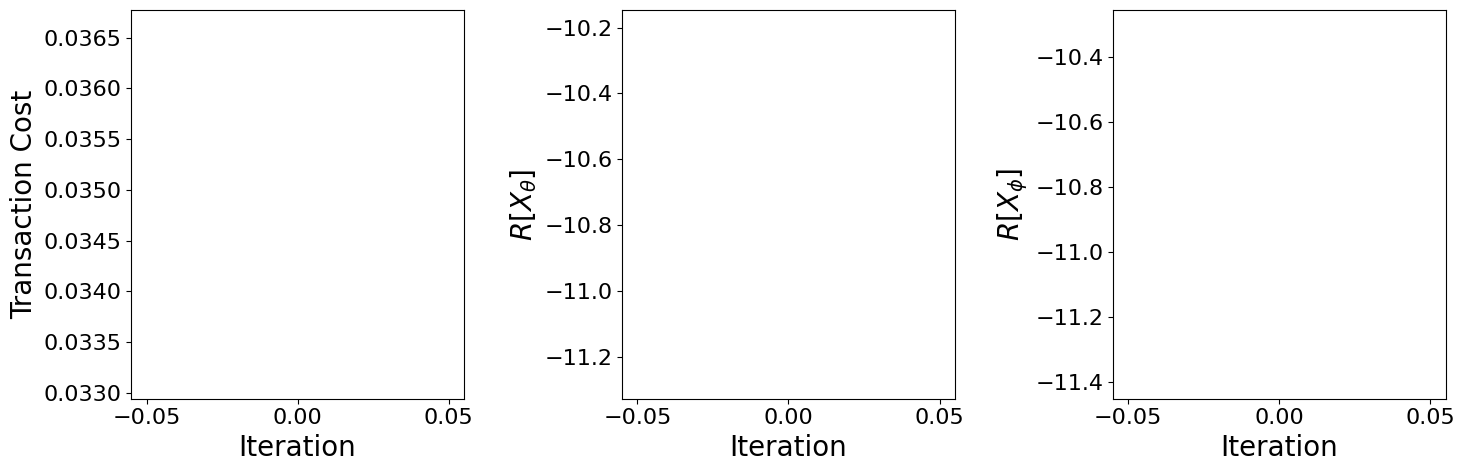

Outer Epoch: 50 Outer Iter: 0
Outer Problem Metrics
Inner Problem Metrics
Wass Dist History:  [0.15337279438972473, 0.15210580825805664, 0.1533339023590088, 0.15782509744167328, 0.15898433327674866]
Risk Measure X_theta History:  [-14.624780654907227, -14.633158683776855, -14.626121520996094, -14.61276626586914, -14.61046314239502]
Loss History:  [0.9332057237625122, 6.945418357849121, 3.3081579208374023, -4.730375289916992, -6.362286567687988]
Augmented Lagrangian lambda: 10.247433319091797 mu: 138.23999999999998


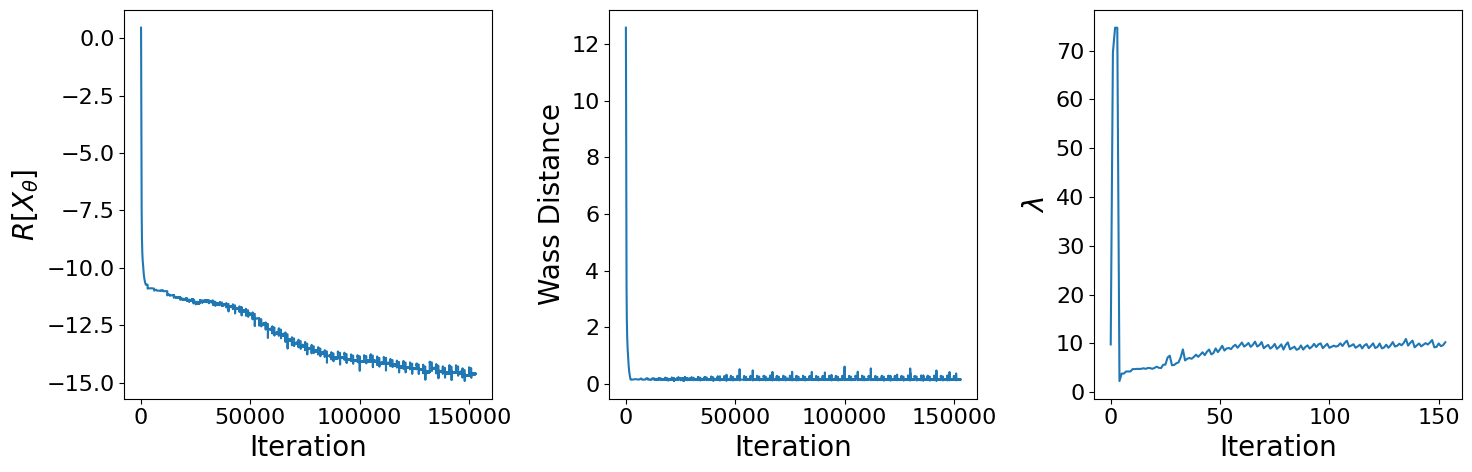

/content/gdrive/My Drive/Colab/RRA_RL/solution.py:156: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X, hist=True, kde= True, label= r'$X^{\phi}$')
/content/gdrive/My Drive/Colab/RRA_RL/solution.py:157: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Y, hist=True, kde= True, label= r'$X^{\theta}$'

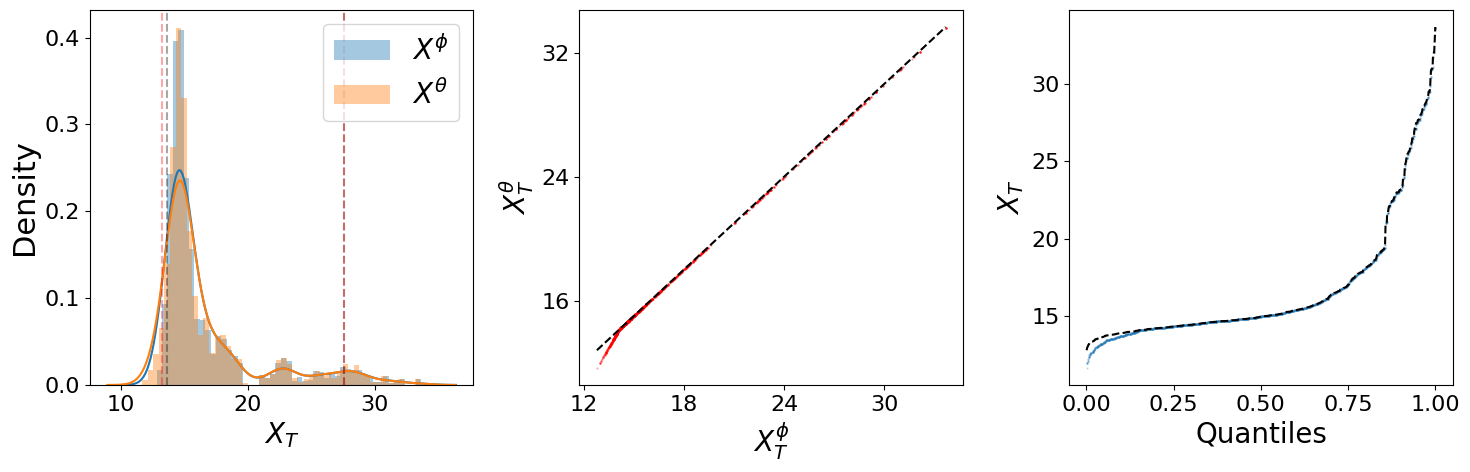

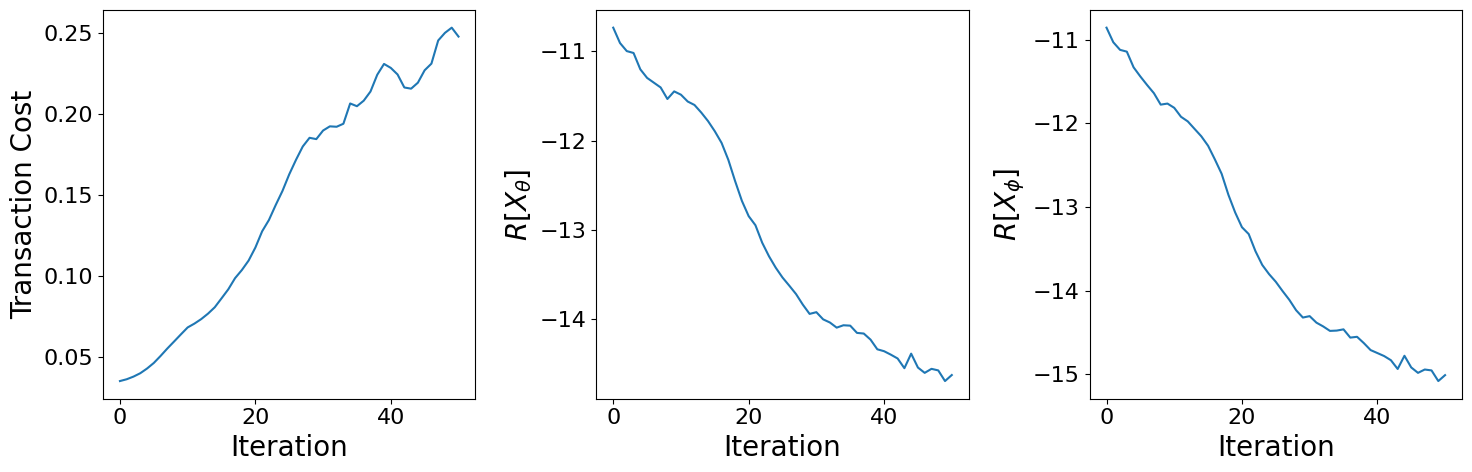

OuterNet(
  (fc_inp_to_h1): Linear(in_features=9, out_features=10, bias=True)
  (fc_h1_h2): Linear(in_features=10, out_features=10, bias=True)
  (fc_h2_out): Linear(in_features=10, out_features=8, bias=True)
  (myReLU): ReLU()
  (mySoftmax): Softmax(dim=2)
)

In [ ]:
agent = EOU_Agent(OU_model, sim_params, train_params, device, outer_net, outer_name)
adversary = OU_Adversary(rm_params, lm_params, wass_params, train_params, device, inner_net, inner_name)
agent.train(adversary)

In [ ]:
np.save(save_dir + "090/" + "wt_history.npy", agent.wt_history)
np.save(save_dir + "090/" + "daily_phi_history.npy", agent.daily_phi_history)
np.save(save_dir + "090/" + "daily_asset_value_history.npy", agent.daily_asset_value_history)
np.save(save_dir + "090/" + "x_phi.npy", agent.X_phi_history)

[5.1236015e-07 4.4199076e-13 1.4178203e-11 3.0010606e-12 1.1747820e-08
 1.4430288e-08 9.9999952e-01 7.6894604e-17]


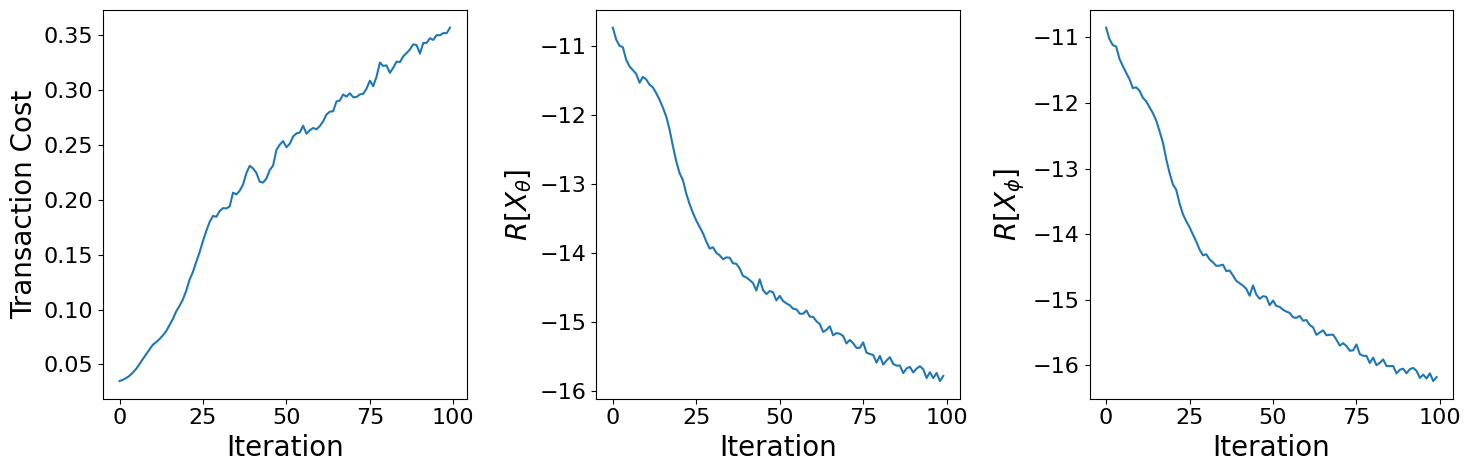

In [ ]:
wt = agent.wt_history[-1]
print(wt[-1, -1])
agent.PlotHistory()

## $\alpha = 0.1, \beta = 0.9, p = 1$

In [ ]:
RM_param_dict = { "alpha" : 0.1,
                  "beta" : 0.9,
                   "p" : 1,
                  "rm_type" : 'alpha-beta'
                  }

rm_params = RM_Params(RM_param_dict)

In [ ]:
inner_net = InnerNet(10).to(device)
outer_net = OuterNet(9, 10, 8).to(device)
inner_name = root_dir + "inner_p_1"
outer_name = root_dir + "outer_p_1"

Outer Epoch: 0 Outer Iter: 0
Outer Problem Metrics
Inner Problem Metrics
Wass Dist History:  [0.14997683465480804, 0.14999105036258698, 0.15000580251216888, 0.14997950196266174, 0.14995834231376648]
Risk Measure X_theta History:  [-11.17104434967041, -11.17103099822998, -11.171015739440918, -11.171041488647461, -11.171060562133789]
Loss History:  [11.194249153137207, 11.194234848022461, -183.1786346435547, 11.194246292114258, 11.194267272949219]
Augmented Lagrangian lambda: 55.90998476028442 mu: 138.23999999999998


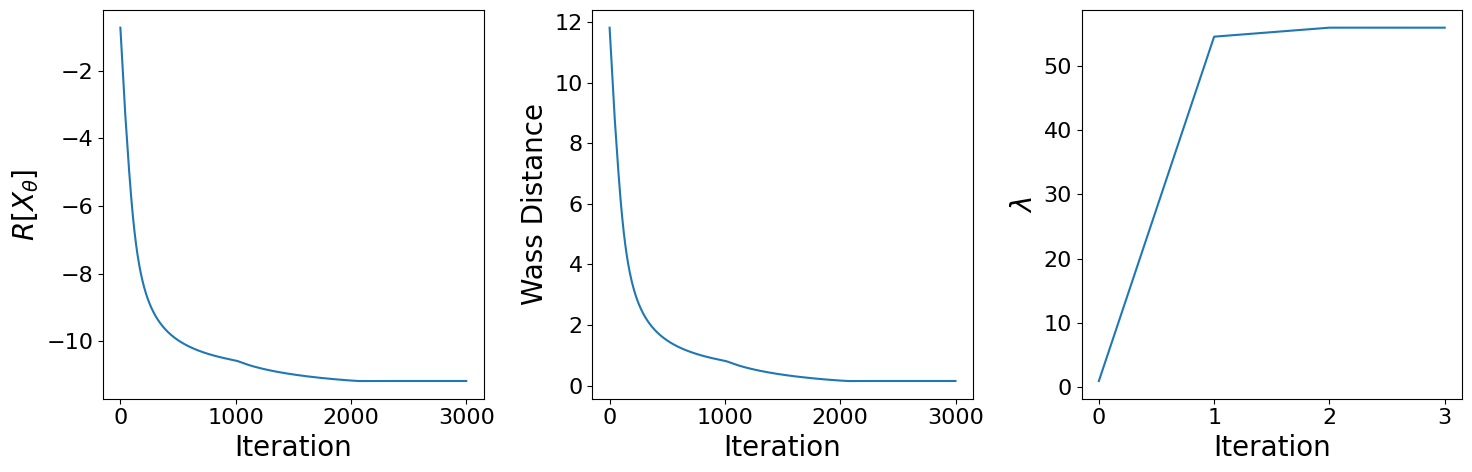

/content/gdrive/My Drive/Colab/RRA_RL/solution.py:156: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X, hist=True, kde= True, label= r'$X^{\phi}$')
/content/gdrive/My Drive/Colab/RRA_RL/solution.py:157: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Y, hist=True, kde= True, label= r'$X^{\theta}$'

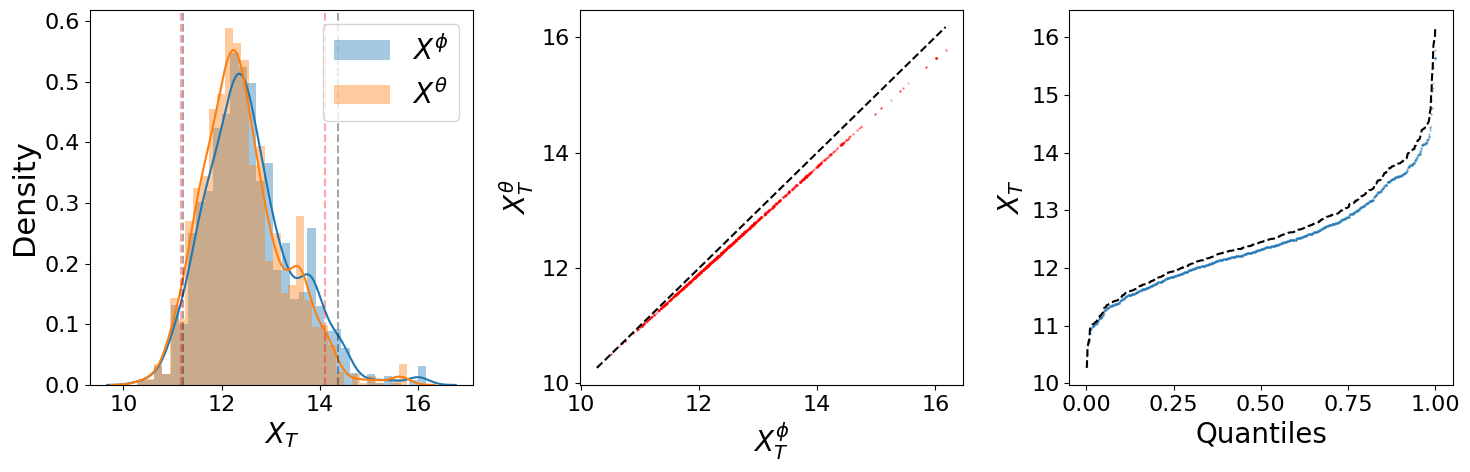

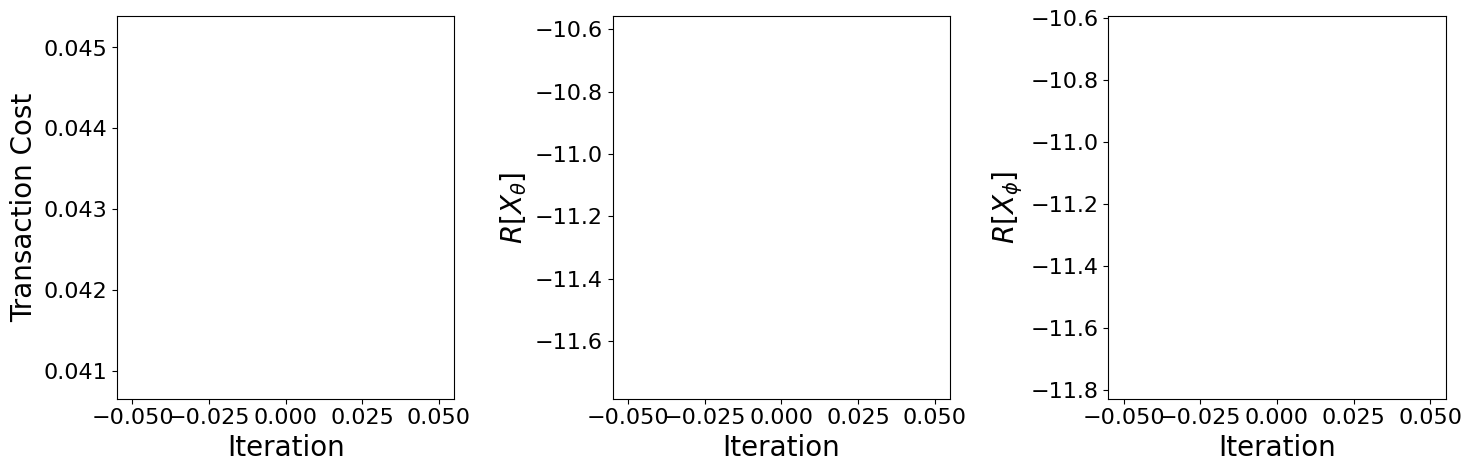

Outer Epoch: 50 Outer Iter: 0
Outer Problem Metrics
Inner Problem Metrics
Wass Dist History:  [0.15304996073246002, 0.15274378657341003, 0.1467336267232895, 0.1530333012342453, 0.15272942185401917]
Risk Measure X_theta History:  [-18.389360427856445, -18.389869689941406, -18.40080451965332, -18.389385223388672, -18.389896392822266]
Loss History:  [-9.407599449157715, -9.124598503112793, 18.532167434692383, -9.401193618774414, -9.120222091674805]
Augmented Lagrangian lambda: 8.329256095886231 mu: 138.23999999999998


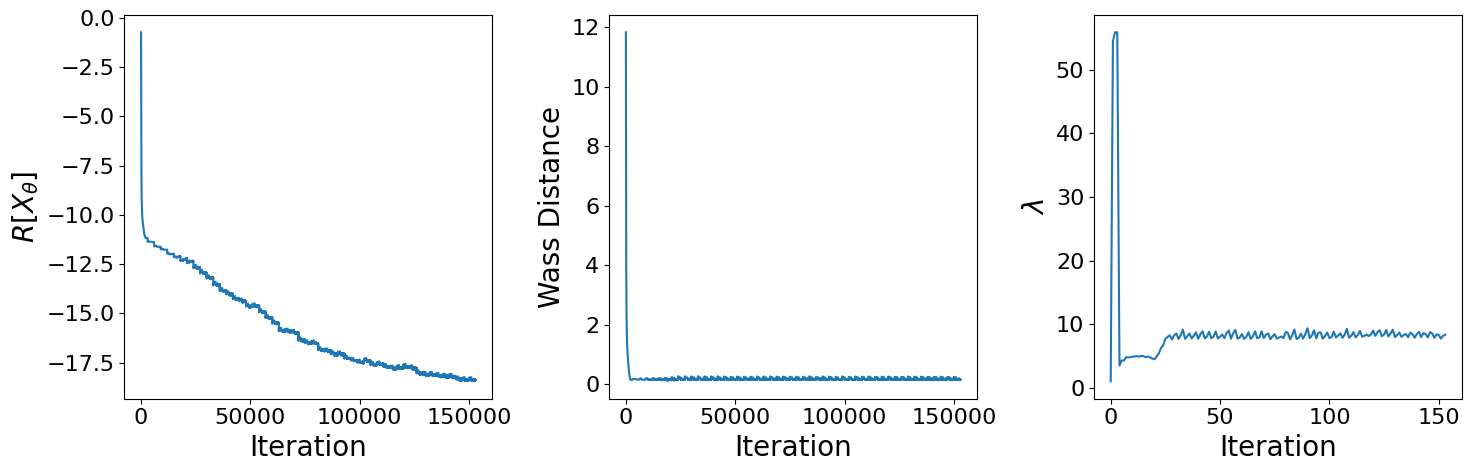

/content/gdrive/My Drive/Colab/RRA_RL/solution.py:156: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X, hist=True, kde= True, label= r'$X^{\phi}$')
/content/gdrive/My Drive/Colab/RRA_RL/solution.py:157: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Y, hist=True, kde= True, label= r'$X^{\theta}$'

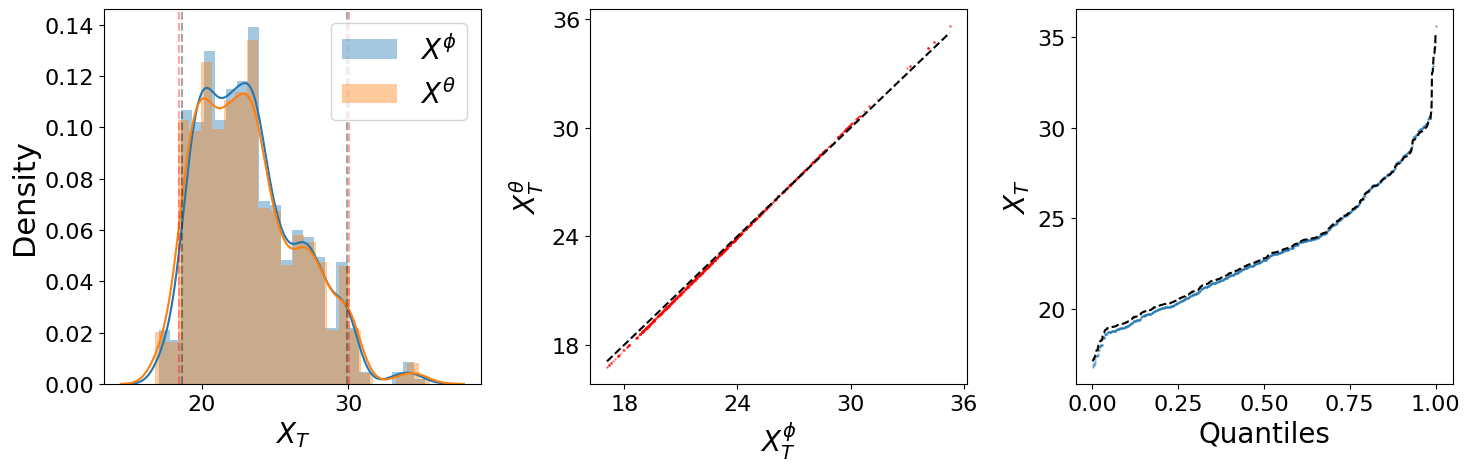

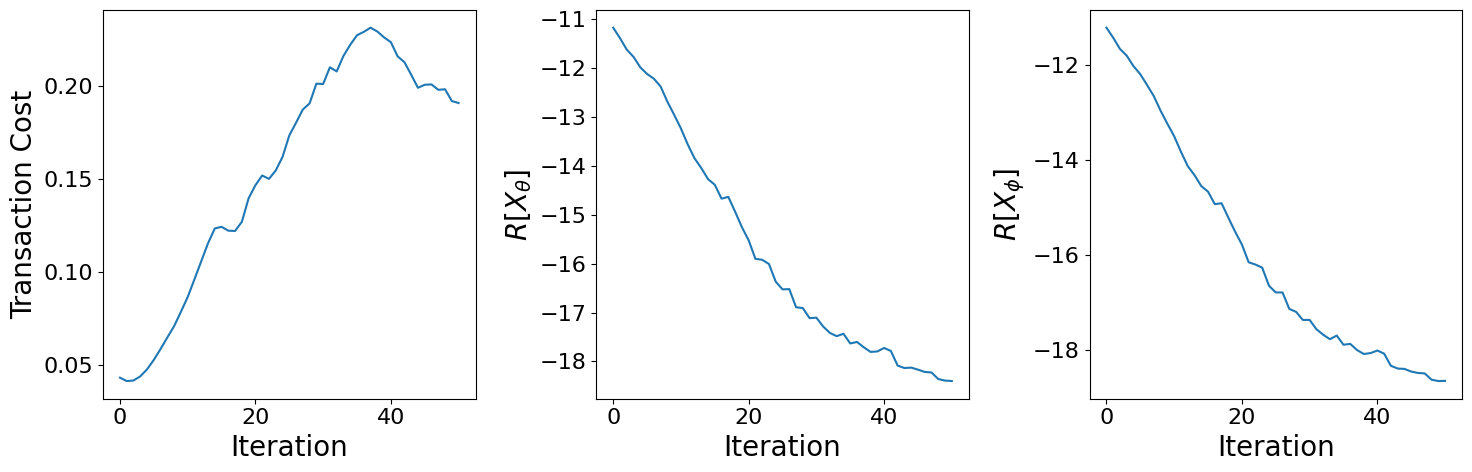

OuterNet(
  (fc_inp_to_h1): Linear(in_features=9, out_features=10, bias=True)
  (fc_h1_h2): Linear(in_features=10, out_features=10, bias=True)
  (fc_h2_out): Linear(in_features=10, out_features=8, bias=True)
  (myReLU): ReLU()
  (mySoftmax): Softmax(dim=2)
)

In [ ]:
agent = EOU_Agent(OU_model, sim_params, train_params, device, outer_net, outer_name)
adversary = OU_Adversary(rm_params, lm_params, wass_params, train_params, device, inner_net, inner_name)
agent.train(adversary)

In [ ]:
np.save(save_dir + "100/" + "wt_history.npy", agent.wt_history)
np.save(save_dir + "100/" + "daily_phi_history.npy", agent.daily_phi_history)
np.save(save_dir + "100/" + "daily_asset_value_history.npy", agent.daily_asset_value_history)
np.save(save_dir + "100/" + "x_phi.npy", agent.X_phi_history)

[7.3375970e-01 1.3587192e-10 4.0906155e-08 1.3545570e-12 2.2354030e-10
 1.4929743e-12 2.6624027e-01 3.9721551e-12]


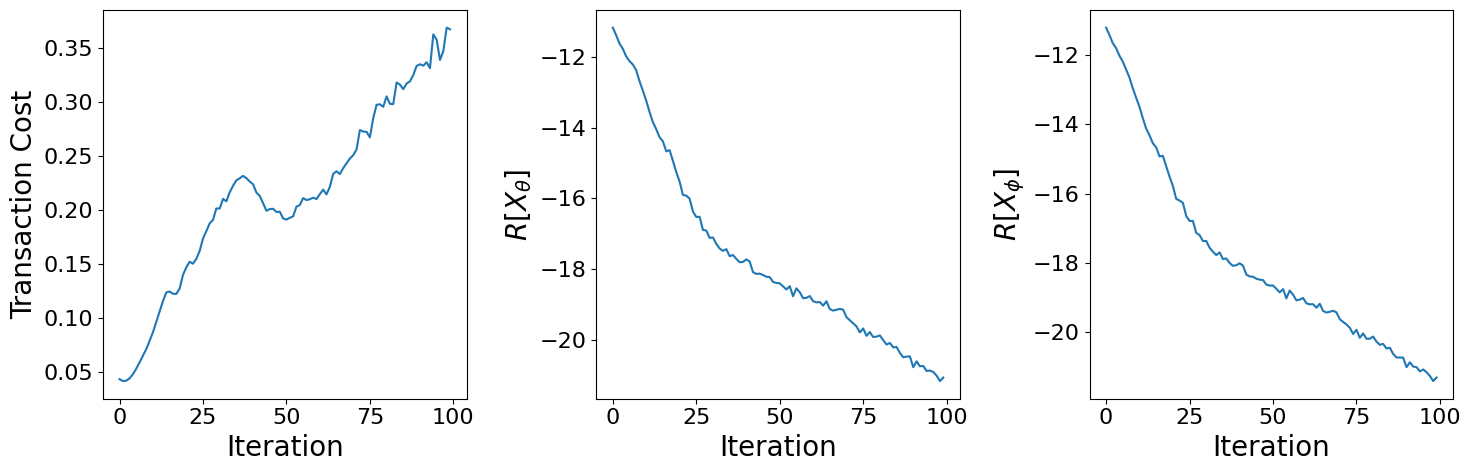

In [ ]:
wt = agent.wt_history[-1]
print(wt[-1, -1])
agent.PlotHistory()